In [1]:
"""
与模型无关的方法
在jupyter环境下运行可输出完整图例
xgb自带的特征重要性和Permutation Importance求出的有所差异，可以综合的生成特征重要性，辅助特征选择。如果Permutation Feature Importance是负的，说明扰乱以后预测效果反而提升了，这种特征应该删除，其他较小的可以删除
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
# import eli5
from pdpbox import pdp, get_dataset, info_plots
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap

"""
2.1 Permutation Feature Importance
"""
# 数据预处理
feature_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country"]
data = pd.read_csv("adult.csv")
labels = data.iloc[:,14]
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
# data = data[:,:-1]

categorical_features = [1, 3, 5, 6, 7, 8, 9,13]

categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data.iloc[:, feature])
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    categorical_names[feature] = le.classes_

data[feature_names] = data[feature_names].astype(float)
# encoder = OneHotEncoder(categorical_features=categorical_features)

# 训练XGBoost模型以及XGB的特征重要性
np.random.seed(1)
train, test, labels_train, labels_test = train_test_split(data[feature_names], labels, train_size=0.80)
# encoder.fit(data)
# encoded_train = encoder.transform(train)
# encoded_test = encoder.transform(test)
gbtree = XGBClassifier(n_estimators=2000, max_depth=4, learning_rate=0.05, n_jobs=8)
gbtree.set_params(eval_metric='auc', early_stopping_rounds=100)
gbtree.fit(train, labels_train,eval_set=[(test, labels_test)], verbose=100)

[0]	validation_0-auc:0.87674
[100]	validation_0-auc:0.92157
[200]	validation_0-auc:0.92891
[300]	validation_0-auc:0.93117
[400]	validation_0-auc:0.93225
[500]	validation_0-auc:0.93297
[600]	validation_0-auc:0.93336
[700]	validation_0-auc:0.93344
[800]	validation_0-auc:0.93342
[845]	validation_0-auc:0.93343


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=8,
              num_parallel_tree=None, random_state=None, ...)

           Feature  Importance
7     Relationship    0.313942
5   Marital Status    0.193800
4    Education-Num    0.143859
10    Capital Gain    0.098529
11    Capital Loss    0.048386
0              Age    0.043022
9              Sex    0.042560
12  Hours per week    0.031375
6       Occupation    0.030982
1        Workclass    0.013295
8             Race    0.011870
13         Country    0.010230
2           fnlwgt    0.009941
3        Education    0.008210


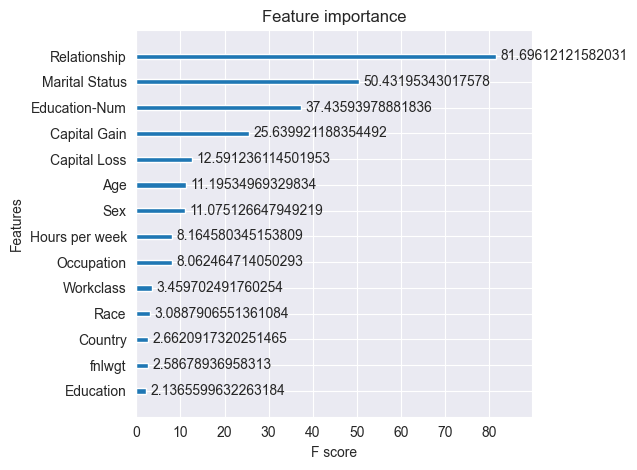

In [2]:
# 获取特征重要性(基于特征的增益（gain）来计算的。增益表示每个特征在分裂时带来的信息增益，也就是这个特征对提升模型性能的贡献)
feature_importances = gbtree.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)
# 绘制特征重要性图(基于每个特征在所有树中被用于分裂的次数来计算特征重要性。这种方法计算的是特征的重要性得分（importance score），也就是每个特征在模型中的出现频次)
plot_importance(gbtree, importance_type='gain')  # 基于信息增益绘制特征重要性
# plot_importance(gbtree, importance_type='weight')  # 基于分裂次数绘制特征重要性
plt.tight_layout()

<Axes: xlabel='importance', ylabel='feat'>

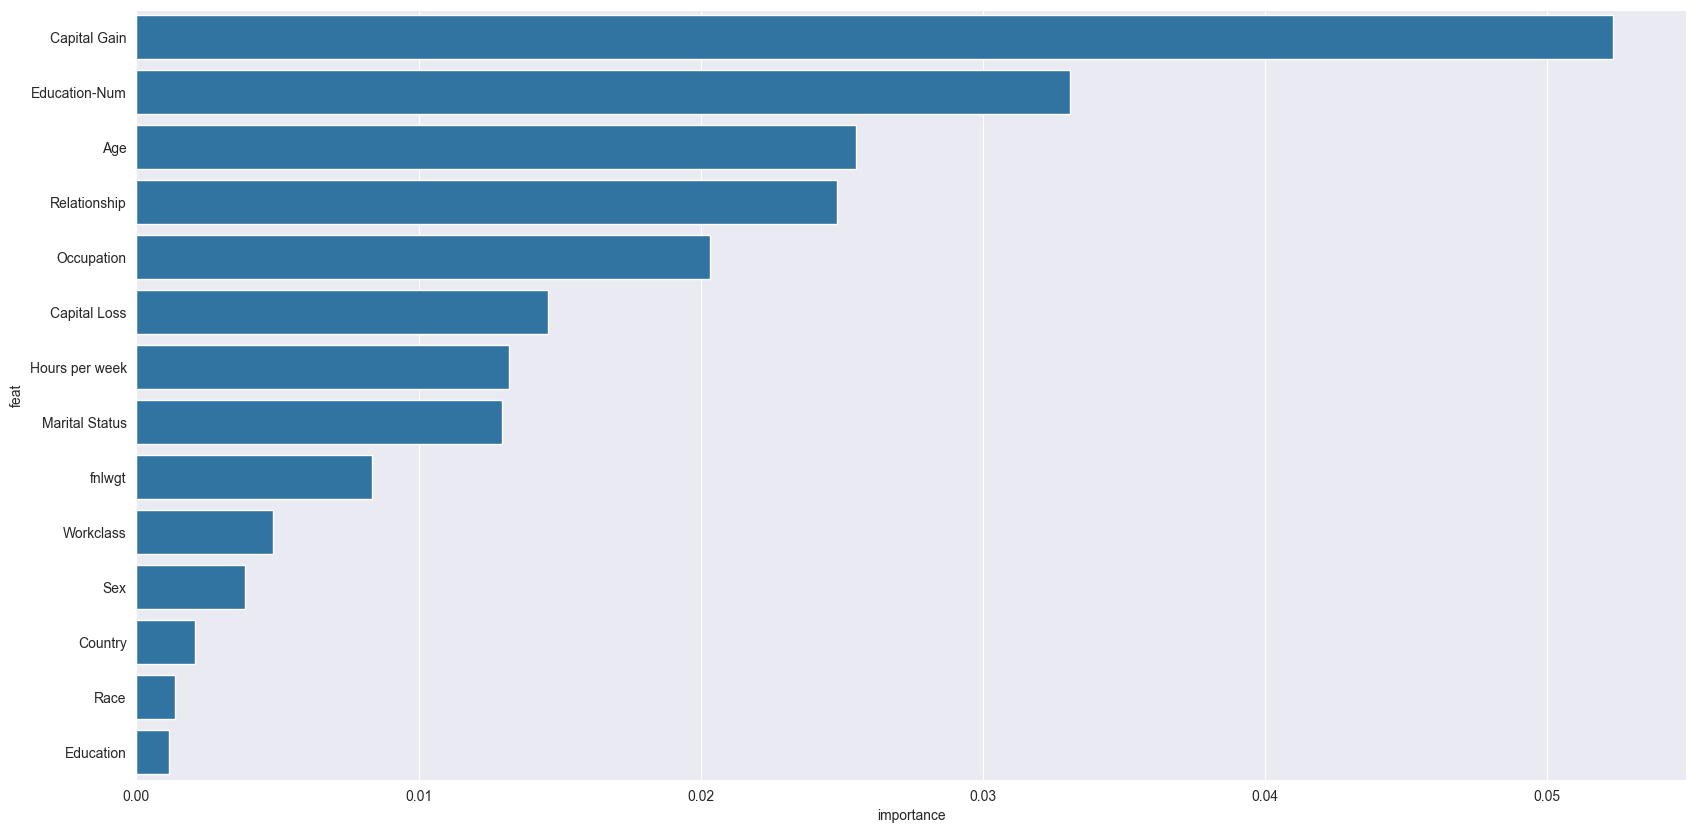

In [3]:
# Permutation Feature Importance-slearn
from sklearn.inspection import permutation_importance
result = permutation_importance(gbtree, train, labels_train, n_repeats=10,random_state=42)
featImp = pd.DataFrame()
featImp['feat'] = feature_names
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x='importance', y='feat', data = featImp[:20], orient='h')

# Permutation Feature Importance-eli5(与sklean库版本不兼容，可降级sklearn库)
# perm = eli5.sklearn.PermutationImportance(gbtree, n_iter=10)
# perm.fit(train, labels_train)
# eli5.show_weights(perm, feature_names=train.columns.tolist())

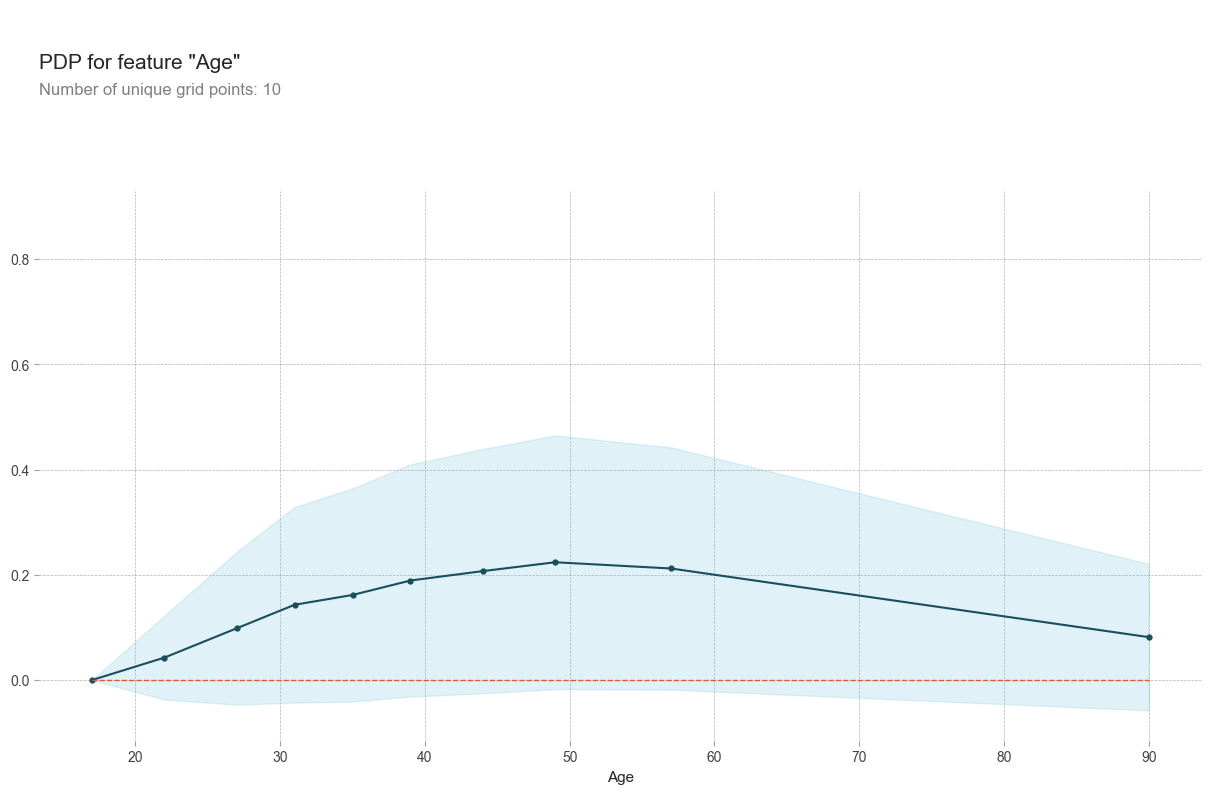

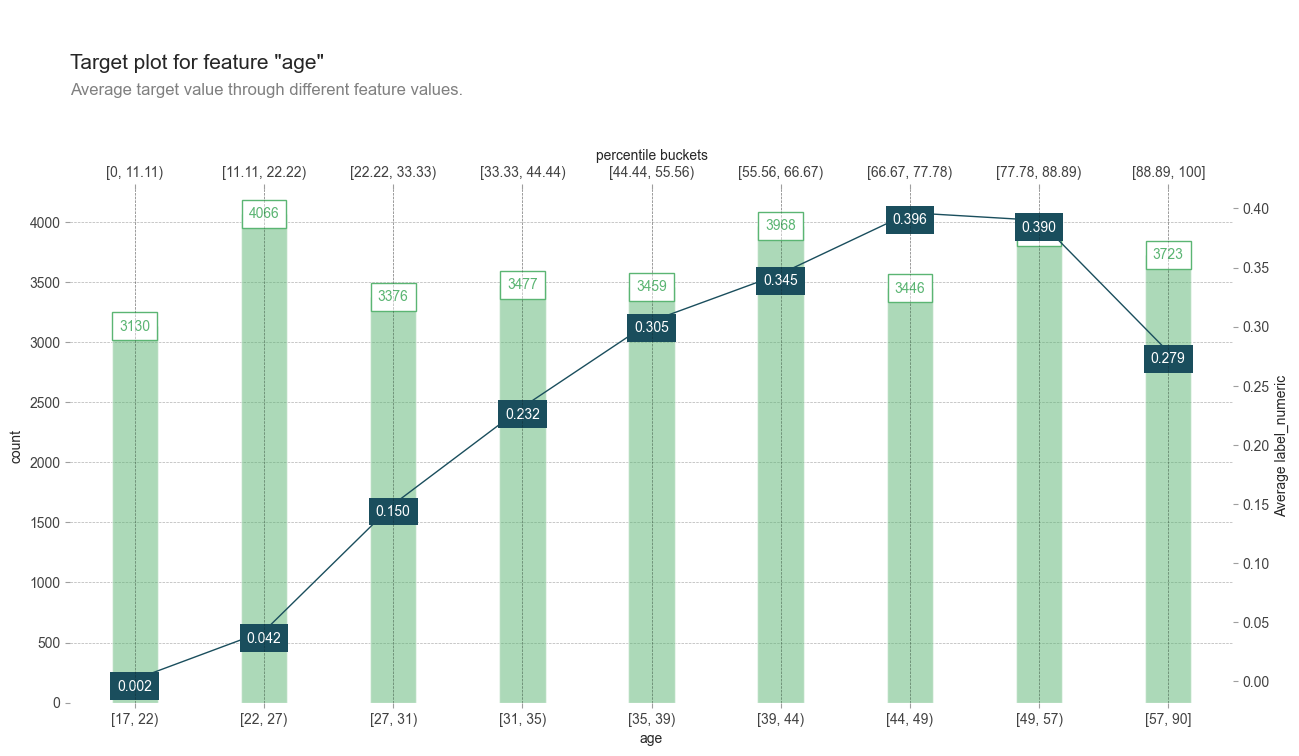

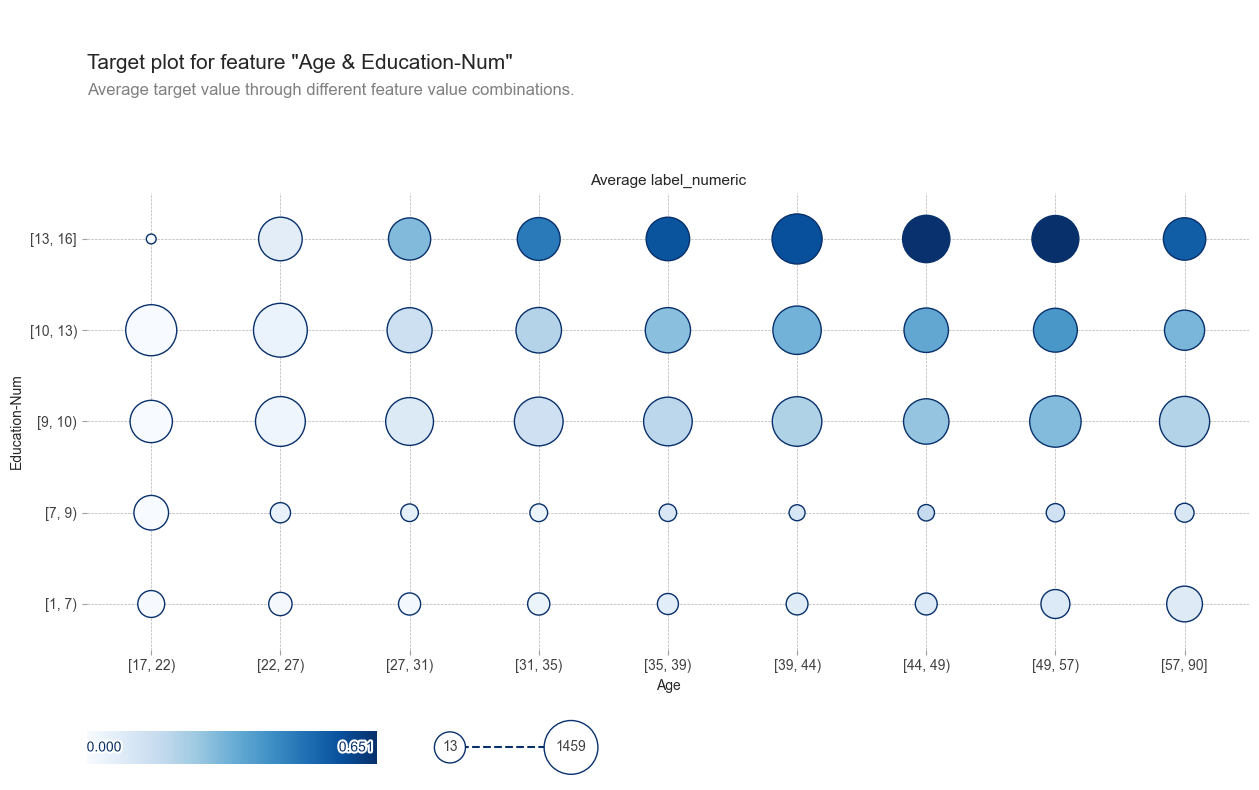

In [4]:
"""
2.2 Partial Dependency Plots
y轴是预测值的变化量，蓝色区域是置信区间。从图中可以看出，中年人，30多岁到60岁，有更高的PDP值，有更高的可能收入大于50K，相比少年和年老的人，这和我们的常识是相统一的
"""
# Age的PDP
pdp_fare = pdp.pdp_isolate(
    model=gbtree, dataset=data, model_features=feature_names, feature='Age'
)
fig, axes = pdp.pdp_plot(pdp_fare, 'Age')

# 不同Age的收入大于50k的比率
data['label_numeric'] = data['label'].apply(lambda x: 1 if x == '>50K' else 0)
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='Age', feature_name='age', target='label_numeric', show_percentile=True
)

# Education-Num和Age交叉特征
fig, axes, summary_df = info_plots.target_plot_interact(
    df=data, features=['Age', 'Education-Num'], feature_names=['Age', 'Education-Num'], target='label_numeric'
)

In [5]:
"""
2.3 ICE（Individual Conditional Expectation）新版的sklearn库下没有plot_partial_dependence
PDP有一个缺点，它描述的是特征变化对整个数据集的影响，ICE能深入到单个样本，分析特征变化对单个样本的影响。求解过程和上述PDP类似，但是ICE会给出每一个样本的预测值
"""
# display = pdp.plot_partial_dependence(
#        est, X_train, features, kind="individual", subsample=50,
#        n_jobs=3, grid_resolution=20, random_state=0
# )
# display.figure_.suptitle(
#     'Individual Conditional Expectation Plot\n'
# )
# display.figure_.subplots_adjust(hspace=0.3)
# plt.show()

'\n2.3 ICE（Individual Conditional Expectation）新版的sklearn库下没有plot_partial_dependence\nPDP有一个缺点，它描述的是特征变化对整个数据集的影响，ICE能深入到单个样本，分析特征变化对单个样本的影响。求解过程和上述PDP类似，但是ICE会给出每一个样本的预测值\n'

In [6]:
"""
2.4 LIME(Local Interpretable Model-Agnostic Explanation)
该模型是一个局部可解释模型，并且是一个与模型自身的无关的可解释方法。通过扰动输入样本（perturb the input），来对模型的预测结果进行解释。该算法不止适用于表格型（tabular）数据，而且适用于文本和图片任务
"""
np.random.seed(1)
i = 16
explainer = LimeTabularExplainer(train.values, feature_names=feature_names, class_names=class_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=3)
predict_fn = lambda x: gbtree.predict_proba(x)
exp = explainer.explain_instance(test.iloc[i].values, predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)

# 另一个例子
i = 10
exp = explainer.explain_instance(test.iloc[i].values, predict_fn, num_features=5)
exp.show_in_notebook(show_all=True)

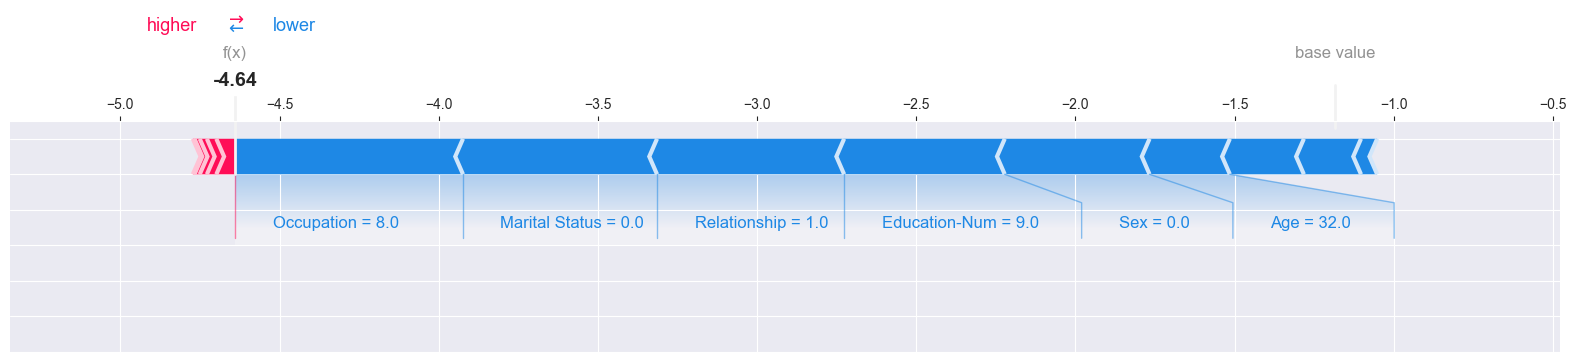

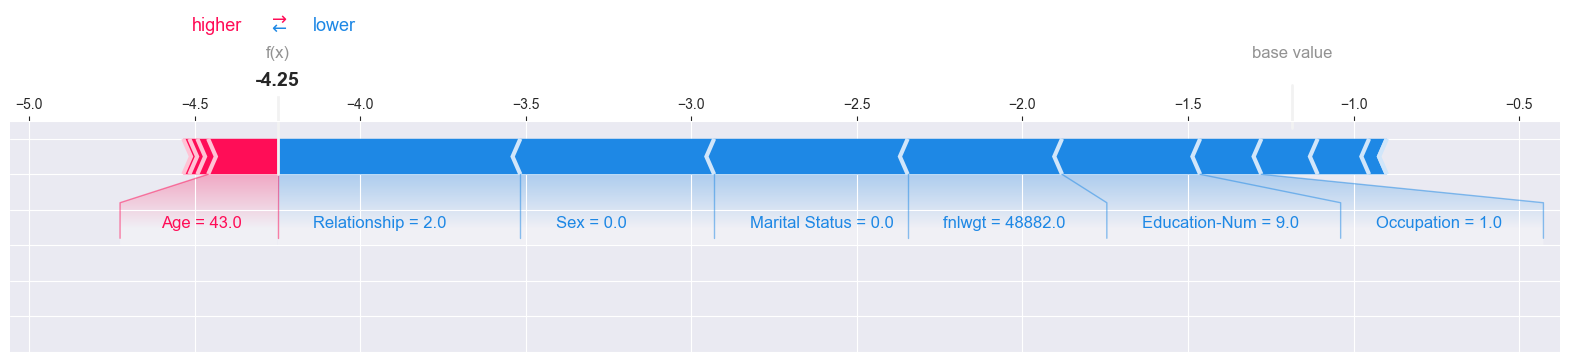

In [ ]:

"""
2.5 SHAP(Shapley Additive explanation)
"""
explainer = shap.TreeExplainer(gbtree)
shap_values = explainer.shap_values(test)

# 对一个样本求shap值，各个特征对output所带来的变化
shap.force_plot(explainer.expected_value, shap_values[16,:], test.iloc[16,:], matplotlib=True)

# 另一个样例
shap.force_plot(explainer.expected_value, shap_values[10,:], test.iloc[10,:], matplotlib=True)

# 将上图旋转90°，然后将所有的test拼接在一起，可以看到在整个数据集上Shap分布
shap.force_plot(explainer.expected_value, shap_values, test)
plt.show()

# 从特征维度，观察特征对Shap的影响
shap.summary_plot(shap_values, test, sort=True)

